In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

SRC_DATA_DIR = './source_data'
PR01_STAGEI_PABS_FEATS_FN = 'StageI-PR01_Absolute_Power_5min_windows.csv'
PR01_STAGEI_SYMPTOM_STATES_FN = 'StageI-PR01_Biomarker_Selected_Symptom_States.csv'
PR01_STAGEI_MODEL_PERF_FN = 'StageI-PR01_Biomarker_Model_Performance-Contacts_and_Band.txt'

In [2]:
def rkfold(X, y, n_feats=6, n_ite=200, n_splits=2):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    scores = list()
    scores_shuffled = list()    
    top_feats = list()
    accuracy = list()
    accuracy_shuffled = list()
    df_roc = list()
    df_roc_shuffled = list()
    for iii in range(n_ite):
        for train_idx, test_idx in kfold.split(X, y):
            pipe = Pipeline([('norm', StandardScaler()),
                             ('fselect', SelectKBest(f_classif, n_feats)), 
                             ('logit', LogisticRegression(class_weight='balanced', solver='lbfgs'))]) 
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            probas = pipe.predict_proba(X.iloc[test_idx])
            preds = pipe.predict(X.iloc[test_idx])
            accuracy.append(accuracy_score(y.iloc[test_idx], preds))
            accuracy_shuffled.append(accuracy_score(y.iloc[test_idx], np.random.permutation(preds)))
            scores.append(roc_auc_score(y.iloc[test_idx], probas[:, 1]))
            scores_shuffled.append(roc_auc_score(y.iloc[test_idx], np.random.permutation(probas[:, 1])))  
            top_feats.extend(X.columns[pipe.named_steps['fselect'].get_support(indices=True)])
            
            tpr, fpr, _ = roc_curve(y.iloc[test_idx], probas[:, 1])
            df_roc.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
            
            tpr, fpr, _ = roc_curve(y.iloc[test_idx], np.random.permutation(probas[:, 1]))
            df_roc_shuffled.append(pd.DataFrame({'tpr': tpr, 'fpr': fpr, 'iter': iii*np.ones(len(tpr))}))
            
    df_roc = pd.concat(df_roc)
    df_roc_shuffled = pd.concat(df_roc_shuffled)    
    return scores, scores_shuffled, df_roc, df_roc_shuffled, accuracy, accuracy_shuffled, pd.value_counts(top_feats, normalize=False) / (n_ite * n_splits)

def fit_and_summary(X, y, outfn, n_feats=6):
    X = X.apply(zscore)
     
    F, p = f_regression(X, y)
    feats = pd.Series(data=F, index=X.columns).sort_values(ascending=False)[:6].index   
    
    X2 = sm.add_constant(X[feats])
    fit = sm.Logit(y, X2).fit(disp=0)

    scores, scores_shuffled, curve, curve_shuffled, accuracy, accuracy_shuffled, top_feats = rkfold(X, y, n_feats)
    
    summary = fit.summary()
    auc_stats = pd.Series(scores).describe()
    auc_stats_shuffled = pd.Series(scores_shuffled).describe()    
    accuracy = pd.Series(accuracy).describe()    
    accuracy_shuffled = pd.Series(accuracy_shuffled).describe()        
    
    '''
    with open(outfn, 'w') as f:
        f.write('ROC AUC Stats from 1000 Randomly Sampled Models\n')
        f.write('----------------------------------------------\n')
        f.write(auc_stats.to_string() + '\n')
        f.write(summary.as_text())
    '''

    print('ROC AUC Stats from 1000 Randomly Sampled Models')
    print('----------------------------------------------')
    print(' ')
    print(auc_stats)
    
    print('Accuracy Stats from 1000 Randomly Sampled Models')
    print('----------------------------------------------')
    print(' ')
    print(accuracy)

    print(' ')
    print(summary)
    
    plt.figure()
    ax = plt.subplot(111)
    ax = sns.lineplot(x='tpr', y='fpr', data=curve, color='blue', linewidth=0.1, ax=ax);
    ax = sns.lineplot(x='tpr', y='fpr', data=curve_shuffled, color='gray', linewidth=0.1, ax=ax);    
    ax.plot([0, 1], [0, 1], color='black', linestyle='--')    
    ax.set_xlim([0, 1]);
    ax.set_ylim([0, 1]);
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(['True: AUC={:0.2f}'.format(auc_stats['mean']),
               'Shuffled: AUC={:0.2f}'.format(auc_stats_shuffled['mean'])])
    sns.despine()
    plt.savefig('{}.pdf'.format(outfn), transparent=True)    
    plt.show()    
    
    return top_feats

# Load Features and Scores

In [3]:
SYMPTOM_STATES = pd.Series.from_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_SYMPTOM_STATES_FN), parse_dates=False)
PABS_FEAT = pd.read_csv(os.path.join(SRC_DATA_DIR, PR01_STAGEI_PABS_FEATS_FN), index_col=0)
PABS_FEAT.drop(['anx', 'nrg', 'dpr', 'ham'], axis=1, inplace=True)

cdf = PABS_FEAT.loc[SYMPTOM_STATES.index]

/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/pandas/core/series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


## Summarize performance across 1000 randomly sampled models

ROC AUC Stats from 1000 Randomly Sampled Models
----------------------------------------------
 
count    400.000000
mean       0.793172
std        0.127607
min        0.181818
25%        0.727273
50%        0.811869
75%        0.878788
max        1.000000
dtype: float64
Accuracy Stats from 1000 Randomly Sampled Models
----------------------------------------------
 
count    400.000000
mean       0.743595
std        0.090168
min        0.444444
25%        0.696078
50%        0.764706
75%        0.777778
max        1.000000
dtype: float64
 
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   35
Model:                          Logit   Df Residuals:                       28
Method:                           MLE   Df Model:                            6
Date:                Tue, 13 Jul 2021   Pseudo R-squ.:                  0.4786
Time:                        12:50:44   Log-Likelihood:   

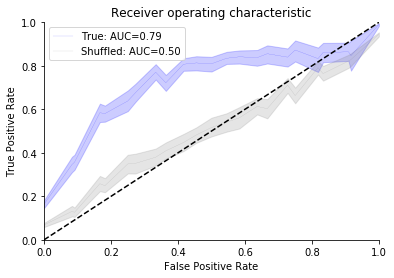

In [4]:
top_feats = fit_and_summary(cdf, SYMPTOM_STATES, os.path.join(SRC_DATA_DIR, PR01_STAGEI_MODEL_PERF_FN))

## Frequency of feature selection across 1000 random models

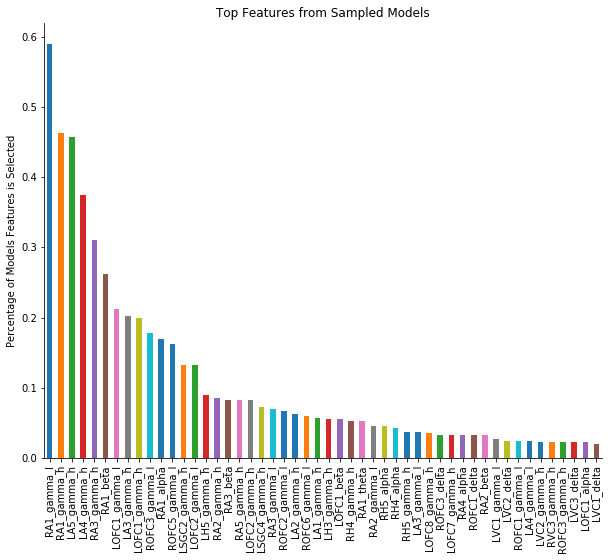

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))
top_feats[:50].plot(kind='bar');
ax.set_ylabel('Percentage of Models Features is Selected')
ax.set_title('Top Features from Sampled Models')
sns.despine();